## Statistical Inference
This analysis includes implementation of new variables for significant missingness regarding the target variable, missing value imputation, encoding for categorical variables, normalisation, feature selection and logistic regression using the loan application data (https://www.kaggle.com/c/home-credit-default-risk/data).  We learned that there are significant missing values, and they seem to affect the outcome of the taget variable from earlier study (https://github.com/DianePark/Predictive-modelling-with-Python/blob/master/03_HLC_Wrangling.ipynb). So we here implement indicator variables for those in advance to any further steps.  
Our target variable is the indicator of risk not to repay their loan, and we want to build a logistic regression model to predict the target correctly from a large number of predictor variables.  Encoding is a way to change categorical values to numeric to make modelling easier - we apply label encoding for variables with less than or equal to two categories and one-hot encoding for ones with more than two categories (https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/).  Missing imputation will be done with median of observed data in each variable and followed by normalisation to eliminate the effect of noises and ensure the model is stable.
In this analysis, we want to go a bit deeper in feature selection engineering - applying three different techniques - namely feature importance, recursive feature elimination and univariate selection - and compare their ROC AUC scores(https://machinelearningmastery.com/feature-selection-machine-learning-python/).

In [1]:
# Loading packges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import LabelEncoder, Imputer, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import timeit
import warnings
warnings.filterwarnings(action = 'ignore')

C:\Users\dpark\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Loading data (307511, 122)
application = pd.read_csv('application_train.csv')

In [3]:
# First five rows of data
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Frequencies of TARGET
target_counts = application.TARGET.value_counts(dropna = False)
target_frac = target_counts[1] / len(application.TARGET) 
target_perc = round(target_counts[1] / len(application.TARGET) * 100, 1)
print('Target counts: \n', target_counts, '\n\nTarget percent:', target_perc )

Target counts: 
 0    282686
1     24825
Name: TARGET, dtype: int64 

Target percent: 8.1


## Missing indicator variables
We implement new indicator variables for significant missing variables, i.e. there is a significant difference in Target values between missing an dnon-missing groups.

In [5]:
# Function for computing the percent of missing
def missing_perc(data):
    missing_counts = data.isnull().sum()
    return round(missing_counts / len(data) * 100, 1)

# Function for the percent of target == 1 for missing group
def missing_target_perc(data, target):
    idx = np.where(data.isnull() & target)
    idx_na = np.where(data.isnull())
    if len(idx_na[0]) == 0:
        return 0.0
    else:
        return round(len(idx[0]) / len(idx_na[0]) * 100, 1)
    
# Function for the percent of target == 1 for no-missing group
def no_missing_target_perc(data, target):
    idx = np.where((data.isnull() == 0) & target)
    idx_no_na = np.where(data.isnull() == 0)
    return round(len(idx[0]) / len(idx_no_na[0]) * 100, 1)

# Function for Chi-square test
def chi_sq_test(data, target):
    """ Find any significant diffence in target values ("No_risk" or "Risk") 
        between missing and non-missing groups of data """
    
    # Contegency table
    cross_tab = pd.crosstab(data.isnull(), target)
    cross_tab.columns = ['No_risk', 'Risk']
    cross_tab.index = ['No_missing', 'Missing']
    cross_tab['prob'] = cross_tab.Risk / (cross_tab.No_risk + cross_tab.Risk)
    ct = cross_tab[['No_risk', 'Risk']] # table without prob column   
    
    # Probabilities of 'Risk' for no-missing, missing and population
    no_na_p = cross_tab.prob[0]
    na_p = cross_tab.prob[1]
    pop_p = target_frac
    
    # Chi-squre statistic
    observed = ct.Risk
    expected = ct.sum(axis = 1) * pop_p
    chi_sq = ((observed - expected) ** 2 / expected).sum().sum()
    
    # Margin-of-error, 95% confidence interva and p-vlaue
    se = np.sqrt(np.sum([no_na_p * (1 - no_na_p) / ct.sum(axis = 1)[0], na_p * (1 - na_p) / ct.sum(axis = 1)[1]]))
    margin_of_error = stats.norm.ppf(.975) * se
    conf_int_95 = [pop_p - margin_of_error, pop_p + margin_of_error]
    p = 1 - stats.chi2.cdf(chi_sq, df = 1)
    
    return p

In [6]:
# Missing-value, target == 1 among missing, target == 1 among no-missing percents
tr_data = application.drop('TARGET', axis = 1) # drop TARGET column
tr_target = application.TARGET # only TARGET column
ms_percs = np.empty(len(tr_data.columns)) # initialise array for missing
ms_tg_percs = np.empty(len(tr_data.columns)) # initialise for msiing and target
no_ms_tg_percs = np.empty(len(tr_data.columns)) # initialise for no-msiing and target
i = -1

for col in tr_data.columns:
    i += 1
    data = tr_data[col]
    ms_percs[i] = missing_perc(data)
    ms_tg_percs[i] = missing_target_perc(data, tr_target)
    no_ms_tg_percs[i] = no_missing_target_perc(data, tr_target)

    # Data frame
df_percs = pd.DataFrame(tr_data.columns)
df_percs.columns = ['variable']
df_percs['na_percent'] = ms_percs
df_percs['na_target_percent'] = ms_tg_percs
df_percs['no_na_target_percent'] = no_ms_tg_percs
df_percs = df_percs.sort_values(by = ['na_percent'], ascending = False)

In [7]:
# Compute p-values of Chi-squre tests
df_missing = df_percs.loc[df_percs.na_percent > 0]
chi_sq_p = np.empty(len(df_missing.variable)) # initialise array

for i in range(len(df_missing.variable)):
    col = list(df_missing.variable)[i]
    data = tr_data[col]
    chi_sq_p[i] = chi_sq_test(data, tr_target)
    
chi_sq_p = pd.DataFrame(chi_sq_p)
chi_sq_p.columns = ['p_value']
chi_sq_p.index = df_missing.variable
sig_na_cols =  list(chi_sq_p[chi_sq_p.p_value <= .05].index)

# p-values less than 0.05
print('p_value of less than 0.05: ', sum(chi_sq_p.p_value <= .05), '\nTotal missing: ', len(chi_sq_p.p_value),
     '\nPercent of significance: ', round(sum(chi_sq_p.p_value <= .05) /len(chi_sq_p.p_value) * 100, 2))

p_value of less than 0.05:  62 
Total missing:  64 
Percent of significance:  96.88


In [8]:
# Create missing indication columns
for col in sig_na_cols:
    ind_col = col + '_na'
    application[ind_col] = np.where(application[col].isnull(), 1, 0)
application.shape

(307511, 184)

## Encoding categorical data
We apply LabelEncoder and pd.get_dummies to make new binary variables from categorical variables.

In [9]:
# Label encoding for 2-category variables 
le = LabelEncoder()

for col in application.columns:
    if application[col].dtype == 'object':
        if len(list(application[col].unique())) <= 2:
            le.fit(application[col])
            application[col] = le.transform(application[col])

In [10]:
# One-hot encoding for 3- or more-category variables
application = pd.get_dummies(application)
application.shape

(307511, 305)

In [11]:
# Save feature names 
feature_names = application.columns.drop('TARGET')
variable_names = application.columns

In [12]:
# Split X and y
X = application.drop(['TARGET'], axis = 1)
y = application.TARGET

## Imputaion 
We impute missing values based on their median for each column.

In [13]:
# Imputation
imputer = Imputer(strategy = 'median')
imputer.fit(X)
X_imputed = imputer.transform(X) #numpy.ndarray'

## Normalisation
If the range of values in a column is large, we cannot build a solid model. So, we normalise all the columns in a range of (0, 1).

In [14]:
# Normalisation
scaler = MinMaxScaler(feature_range = (0, 1), copy = True)
scaler.fit(X_imputed)
X_normed = scaler.transform(X_imputed)

## Feature selection
We use three methods to selecet features and test them using ROC AUC metric.

* Feature importance: baggd decision tree using ExtraTreesClassifier
* Recursive feature elimination: recursively removing features 
* Univariate selection: features having strongest relationship with the target using statistical tests

### Feature importance

In [15]:
# Feature importance
etc = ExtraTreesClassifier()
etc.fit(X_normed, y)
score = pd.DataFrame({'Feature': feature_names, 'Score': etc.feature_importances_})
score.sort_values(by = ['Score'], ascending = False, inplace = True)

In [16]:
# Cut the score at 0.002
feature_fi = list(score.loc[score.Score >= .002].Feature)
k = score.loc[score.Score >= .002].shape[0]
score.loc[score.Score >= .002].shape

(139, 2)

In [17]:
score.loc[score.Score >= .002]


,Feature,Score
32,EXT_SOURCE_2,0.029469
33,EXT_SOURCE_3,0.027337
10,DAYS_BIRTH,0.020248
81,DAYS_LAST_PHONE_CHANGE,0.018942
13,DAYS_ID_PUBLISH,0.018777
12,DAYS_REGISTRATION,0.018562
0,SK_ID_CURR,0.018486
5,AMT_INCOME_TOTAL,0.017918
7,AMT_ANNUITY,0.017821
24,HOUR_APPR_PROCESS_START,0.017794


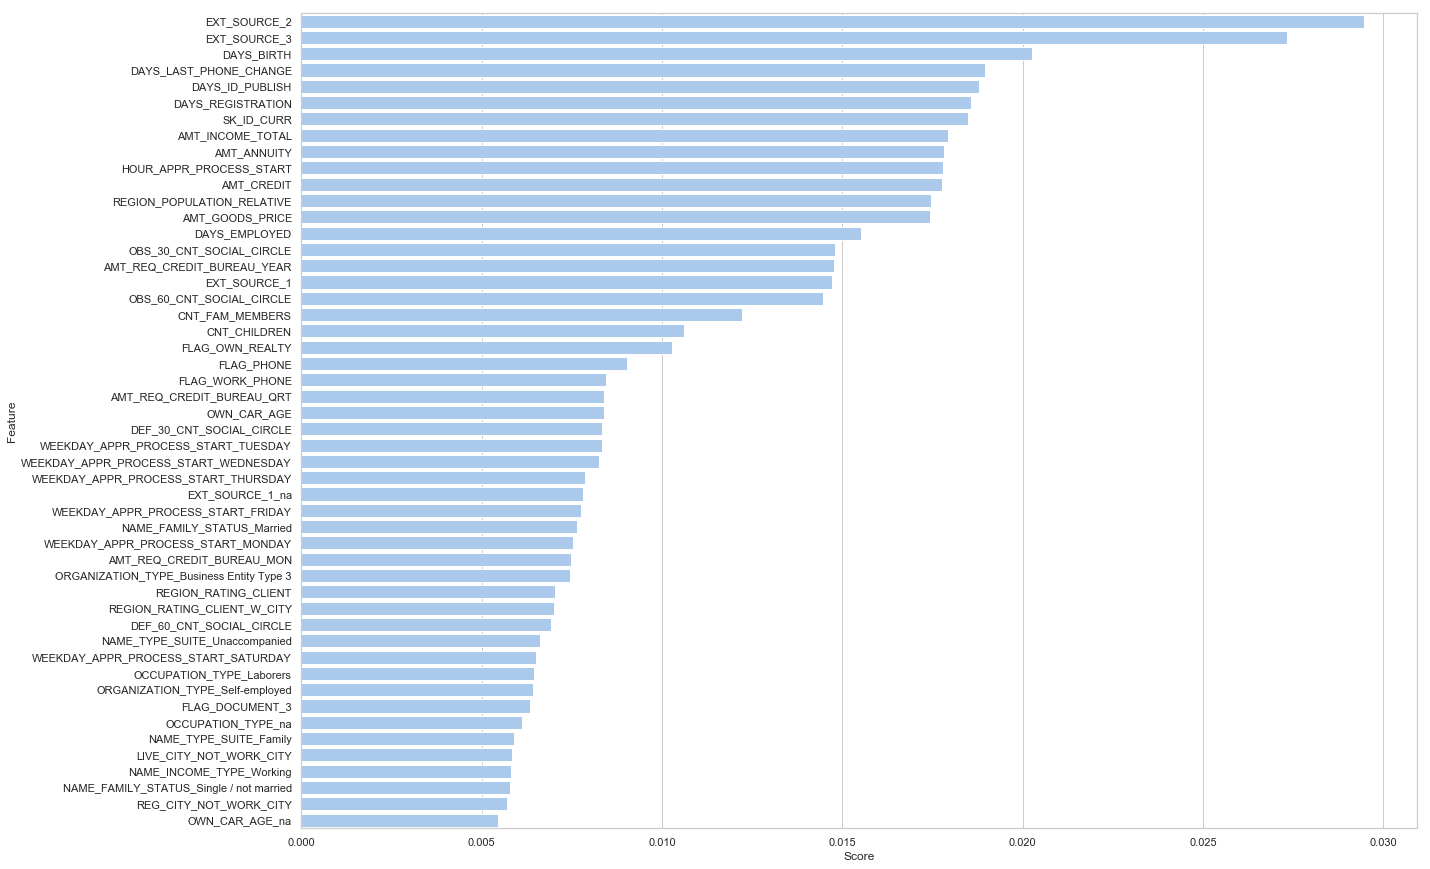

In [18]:
# Visualise the important feafures with its score
sns.set(style = 'whitegrid')
f, ax = plt.subplots(figsize = (20, 15)) # initialise the matplot plane

score_top50 = score.iloc[:50]

# Plot 
_ = sns.set_color_codes('pastel')
_ = sns.barplot(x = 'Score', y = 'Feature', data = score_top50, color = 'b')
#plt.savefig('feature_importance.png')
plt.show()

In [19]:
# Logistic Regression using k features from feature importance method
features = score.loc[score.Score >= .001].Feature

X_fi = X_normed[:, features.index]

lg = LogisticRegression()
lg.fit(X_fi, y)
pred_prob = lg.predict_proba(X_fi)[:, 1] #probability of prediction for TARGET==1

# ROC-AUC score
score_feature_importance = roc_auc_score(y, pred_prob)
print('Score of feature importance method: {}'.format(score_feature_importance))

Score of feature importance method: 0.7488431114616447


### Recursive feature elimination

In [20]:
# Function for time unit change
def hms (sec):
    sec = round(sec)
    if sec < 60:
        time = str(sec) + ' seconds'
    elif sec < 3600:
        minute = sec // 60
        second = sec % 60
        time = str(minute) + ' minutes ' + str(second) + ' seconds'
    else:
        hour = sec // 3600
        sec = sec % 3600
        minute = sec // 60
        second = sec % 60
        time = str(hour) + ' hours ' + str(minute) + ' minutes' + str(second) + ' seconds'
    return time   

In [21]:
# Recursive feature elimination with k features as same as the earlier ones
start = timeit.default_timer()

lg = LogisticRegression()
rfe = RFE(lg, n_features_to_select = k)
rfe.fit(X_normed, y)
X_rfe = rfe.transform(X_normed)
pred_prob = rfe.predict_proba(X_normed)[:, 1]

stop = timeit.default_timer()
print('Time of computing: {}'.format(hms(stop -  start)))

Time of computing: 1 hours 24 minutes58 seconds


In [22]:
# ROC-AUC score
score_rfe = roc_auc_score(y, pred_prob)
print('Score of recursive feature elimination: {}'.format(score_rfe))

Score of recursive feature elimination: 0.7493910646352574


In [23]:
# Name of selected features
idxs_rfe = rfe.get_support(indices = True)
feature_rfe = feature_names[idxs_rfe]

### Univariate slection

In [24]:
# Univariate selection with k features as same as the earlier ones
kbest = SelectKBest(score_func = chi2, k = k)
kbest.fit(X_normed, y)
X_kbest = kbest.transform(X_normed)

lg = LogisticRegression()
lg.fit(X_kbest, y)
pred_prob = lg.predict_proba(X_kbest)[:, 1]

# ROC-AUC score
score_kbest = roc_auc_score(y, pred_prob)
print('Score of univariate selection: {}'.format(score_kbest))

Score of univariate selection: 0.7442712916823743


In [25]:
# Name of selected features
idxs_kbest = kbest.get_support(indices=True)
feature_kbest = feature_names[idxs_kbest]

## Compare these three selections

In [26]:
# Union of all features
feature_all = list(set(feature_fi) | set(feature_rfe) | set(feature_kbest))
len(feature_all)

266

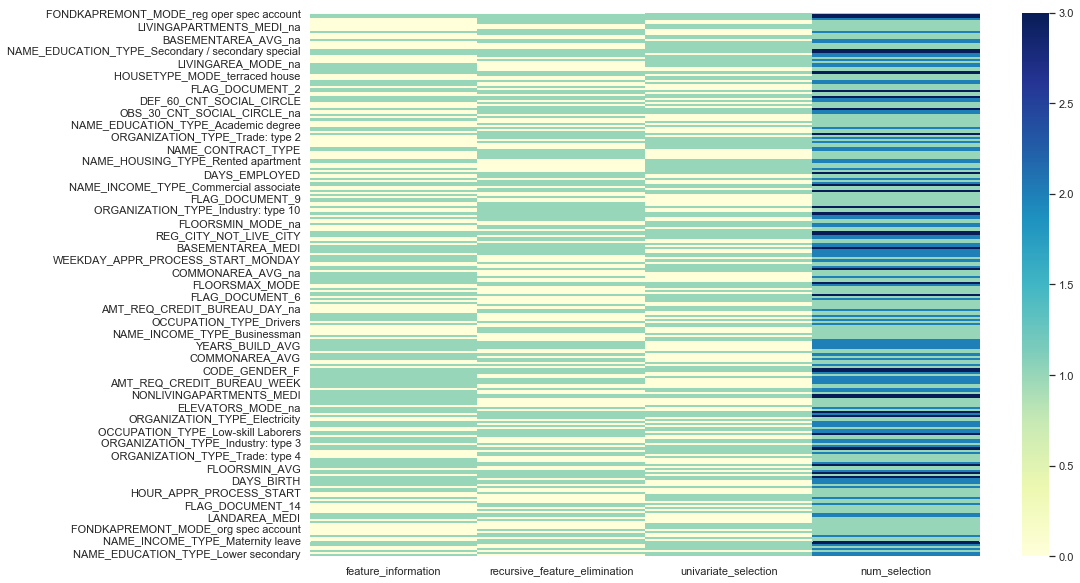

In [30]:
# Heatmap of selection
fi_flag = np.empty(len(feature_all))
rfe_flag = np.empty(len(feature_all))
kbest_flag = np.empty(len(feature_all))

for i in range(len(feature_all)):
    ff = feature_all[i]
    fi_flag[i] = np.where(ff in feature_fi, 1, 0)
    rfe_flag[i] = np.where(ff in feature_rfe, 1, 0)
    kbest_flag[i] = np.where(ff in feature_kbest, 1, 0)
        
feature_df = pd.DataFrame({'feature_information': fi_flag, 
                           'recursive_feature_elimination': rfe_flag, 
                           'univariate_selection': kbest_flag})
feature_df.index = feature_all
feature_df['num_selection'] = feature_df.apply(np.sum, axis = 1)

plt.figure(figsize = (15, 10))
sns.heatmap(feature_df, cmap = 'YlGnBu')
plt.xticks(rotation = 0)
#plt.savefig('feature_selection_comparision.png')
plt.show()

In [28]:
# Number of selecton
print('Number of features selected in all three: {}'.format(np.sum(feature_df.num_selection == 3)),
      '\nNumber of features selected in two: {}'.format(np.sum(feature_df.num_selection == 2)),
      '\nNumber of features selected in one: {}'.format(np.sum(feature_df.num_selection == 1)))

Number of features selected in all three: 32 
Number of features selected in two: 87 
Number of features selected in one: 147
